In [2]:
import cv2 as cv
import numpy as np
import copy

orb = cv.ORB_create(
    nfeatures=10000,
    scaleFactor=1.2,
    scoreType=cv.ORB_HARRIS_SCORE)

class FeatureExtraction:
    def __init__(self, img):
        self.img = copy.copy(img)
        self.gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        self.kps, self.des = orb.detectAndCompute( \
            self.gray_img, None)
        self.img_kps = cv.drawKeypoints( \
            self.img, self.kps, 0, \
            flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        self.matched_pts = []

LOWES_RATIO = 0.7
MIN_MATCHES = 50
index_params = dict(
    algorithm = 6, # FLANN_INDEX_LSH
    table_number = 6,
    key_size = 10,
    multi_probe_level = 2)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(
    index_params,
    search_params)

def feature_matching(features0, features1):
    matches = [] # good matches as per Lowe's ratio test
    if(features0.des is not None and len(features0.des) > 2):
        all_matches = flann.knnMatch( \
            features0.des, features1.des, k=2)
        try:
            for m,n in all_matches:
                if m.distance < LOWES_RATIO * n.distance:
                    matches.append(m)
        except ValueError:
            pass
        if(len(matches) > MIN_MATCHES):    
            features0.matched_pts = np.float32( \
                [ features0.kps[m.queryIdx].pt for m in matches ] \
                ).reshape(-1,1,2)
            features1.matched_pts = np.float32( \
                [ features1.kps[m.trainIdx].pt for m in matches ] \
                ).reshape(-1,1,2)
    return matches

In [9]:
import cv2 as cv
import numpy as np

img0 = cv.imread("./images/lasmeninas0.png", cv.IMREAD_GRAYSCALE)
img1 = cv.imread("./images/lasmeninas1.png", cv.IMREAD_GRAYSCALE)
features0 = FeatureExtraction(img0)
features1 = FeatureExtraction(img1)

matches = feature_matching(features0, features1)
# matched_image = cv.drawMatches(img0, features0.kps, \
#     img1, features1.kps, matches, None, flags=2)

H, _ = cv.findHomography( features0.matched_pts, \
    features1.matched_pts, cv.RANSAC, 5.0)

h, w, c = img1.shape
warped = cv.warpPerspective(img0, H, (w, h), \
    borderMode=cv.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

output = np.zeros((h, w, 3), np.uint8)
alpha = 0#warped[:, :, 3] / 255.0
output[:, :, 0] = (1. - alpha) * img1[:, :, 0] + alpha * warped[:, :, 0]
output[:, :, 1] = (1. - alpha) * img1[:, :, 1] + alpha * warped[:, :, 1]
output[:, :, 2] = (1. - alpha) * img1[:, :, 2] + alpha * warped[:, :, 2]

error: OpenCV(4.10.0) /home/conda/feedstock_root/build_artifacts/libopencv_1727758804785/work/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


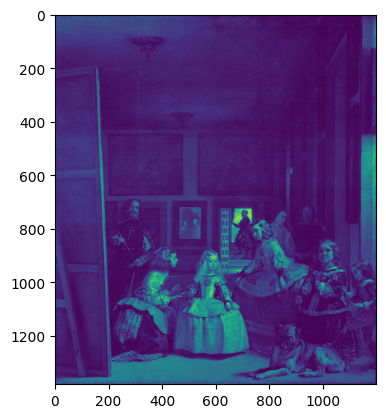

In [10]:
import matplotlib.pyplot as plt
plt.imshow(img0)